In [ ]:
# import libraries
import sqlite3
import pandas as pd
import os
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations, permutations
import statsmodels.api as sm
from statsmodels.formula.api import ols


conn = sqlite3.connect('northWind.sqlite')
cur = conn.cursor()

def get_df_from_SQL(table_name):
    cur.execute(f'''select * from {table_name};''')
    df = pd.DataFrame(cur.fetchall())
    df.columns = [i[0] for i in cur.description]
    return df

def detect_abnormality(lst_of_distributions):
    count = 0
    for i in lst_of_distributions:
        shap = stats.shapiro(i)
        if shap[1] < 0.1:
            print(f"The distribution at index {count} is not normally distributed; the Shapiro test gave it a pvalue of {shap[1]}")
        count += 1

def bootstrap_em(distribution, n=1000):
    means_list = []
    for i in range(n):
        means_list.append(np.random.choice(distribution, len(distribution), replace=True).mean())
    return means_list

def anova_test(formula, df):
    lm = ols(formula, df).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    return table

def cohens_d(arr1, arr2):
    cohens_d = (np.mean(arr1) - np.mean(arr2)) / (np.sqrt((np.std(arr1) ** 2 + np.std(arr2) ** 2) / 2))
    return cohens_d

In [ ]:
# investigate data



In [ ]:
employees = get_df_from_SQL('Employee')

In [ ]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

In [ ]:
get_df_from_SQL('Product')

In [ ]:
cur.execute('''SELECT * FROM OrderDetail;''')

In [ ]:
order_details = get_df_from_SQL('OrderDetail')
order_details.head()

In [ ]:
order_details['TotalPrice'] = (order_details['UnitPrice'] * order_details['Quantity']) * (1 - order_details['Discount'])
order_details[0:10]

In [ ]:
order_details['TotalPrice'].sort_values(ascending=False)[0:20], len(order_details)
employees['Title'].unique()

In [ ]:
order_details['TotalPrice'].mean()
order_details['Discount'].unique()

In [ ]:
cur.execute('''SELECT * FROM 'Order' ORDER BY Id;''')
orders = pd.DataFrame(cur.fetchall())
orders.columns = [i[0] for i in cur.description]
orders.head()

# Question 1: Is there a difference in quantity of products sold by discount rate? 

In [ ]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [ ]:
# perform test

## Conclusion

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

# Question 2: Is there a difference in number of orders and territory? 

In [ ]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [ ]:
# perform test

## Conclusion

# Question 3: Is there any connection between employees and the total prices of the sales they make?

In [131]:
# obtain necessary data
employees = get_df_from_SQL('Employee')
order_details = get_df_from_SQL('OrderDetail')

cur.execute('''SELECT * FROM 'Order' ORDER BY Id;''')
orders = pd.DataFrame(cur.fetchall())
orders.columns = [i[0] for i in cur.description]
orders.head()

# add total price to the order_details sheet
order_details['TotalPrice'] = (order_details['UnitPrice'] * order_details['Quantity']) * (1 - order_details['Discount'])

#merge all sheets
employees.rename(columns={'Id':'EmployeeId'}, inplace=True)
orders.rename(columns={'Id':'OrderId'}, inplace=True)
merged = employees.merge(orders, on='EmployeeId').merge(order_details, on='OrderId')

# chopping out the useless stuff and narrowing our focus on sales reps
emp_w_revenue = merged[['EmployeeId', 'FirstName', 'LastName', 'Title', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount', 'TotalPrice']]
sales_reps = emp_w_revenue.loc[emp_w_revenue['Title'] == 'Sales Representative']
sales_reps.head()

,EmployeeId,FirstName,LastName,Title,OrderId,ProductId,UnitPrice,Quantity,Discount,TotalPrice
0,1,Nancy,Davolio,Sales Representative,10258,2,15.2,50,0.2,608.00
1,1,Nancy,Davolio,Sales Representative,10258,5,17.0,65,0.2,884.00
2,1,Nancy,Davolio,Sales Representative,10258,32,25.6,6,0.2,122.88
3,1,Nancy,Davolio,Sales Representative,10270,36,15.2,30,0.0,456.00
4,1,Nancy,Davolio,Sales Representative,10270,43,36.8,25,0.0,920.00


In [ ]:
# distributions for each sales rep
sales_reps_tp_dists = {}
for rep in sales_reps['FirstName'].unique():
    sales_reps_tp_dists[rep] = np.array(sales_reps.loc[sales_reps['FirstName']==rep].groupby('OrderId').sum()['TotalPrice'])

# print out basic stats for each sales rep
for name in sales_reps_tp_dists:
    print(f"{name}'s average sales price was {round(sales_reps_tp_dists[name].mean(), 2)}, and their total sales were {round(sales_reps_tp_dists[name].sum(), 2)}")

In [ ]:
# a graph of the distributions of each sales reps total sales price per order
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,10))
for rep in sales_reps['FirstName'].unique():
    ax = sns.distplot(sales_reps.loc[sales_reps['FirstName']==rep].groupby('OrderId').sum()['TotalPrice'], label=rep)
ax.legend(fontsize='x-large')
ax.set_title('Total Sales Distributions for Sales Reps', size='xx-large')
ax.set_xlabel('Total Price', size='x-large')
ax.set_xlim(left=0, right=10000)

In [ ]:
# the data doesn't look normal, but let's check
detect_abnormality(sales_reps_tp_dists.values())

In [ ]:
# so we'll use a bootstraping method to get normal distrubtions for each sales rep
reps_bstrap_dists = {}
for name in sales_reps_tp_dists.keys():
    reps_bstrap_dists[name] = bootstrap_em(sales_reps_tp_dists[name], n=1000)

fig, ax = plt.subplots(figsize=(20, 10))
for name in reps_bstrap_dists.keys():
    sns.distplot(reps_bstrap_dists[name], label=name)
ax.legend(fontsize='x-large')
ax.set_title('Normalized Sales Distributions for Sales Reps', size='xx-large')
ax.set_xlabel('Total Price', size='x-large')

In [ ]:
# set data into a dataframe for testing
rep_w_prices = pd.DataFrame.from_dict(reps_bstrap_dists, orient='index').reset_index()
rep_w_prices = pd.melt(rep_w_prices, id_vars=["index"], value_name=0).drop(['variable'],axis=1).sort_values('index')
rep_w_prices = rep_w_prices.rename(columns={'index':'Name', 0:'TotalPrice'})
print(rep_w_prices.describe())
rep_w_prices.head()


## Tukey comparison of sales reps and total price of their sales
H0: there is no connection between who the sales rep is and the sample mean of the total price of their sales

HA: there is some connection between who the sales rep is and the sample mean of the total price of their sales

In [ ]:
# first we conduct an ANOVA test to see if there are any differences at all. 
# if there are, we can use Tukey to get a better understanding of what's going on
formula = 'TotalPrice ~ C(Name)'

anova_test(formula, rep_w_prices)

In [ ]:
# there seems to be significant difference between the employees and the sample means of their total price per order.
# because we are comparing multiple variables, and we wanted to compare the different salespeople to one another 
# individually, a Tukey test was chosen
reps_comp = pairwise_tukeyhsd(endog=rep_w_prices['TotalPrice'], groups=rep_w_prices['Name'], alpha=0.05)
print(reps_comp)

In [ ]:
# since almost none of the null hypotheses were rejected, we reran the test with a lower alpha to see just how sure we could be
reps_comp = pairwise_tukeyhsd(endog=rep_w_prices['TotalPrice'], groups=rep_w_prices['Name'], alpha=0.01)
print(reps_comp)

In [ ]:
# let's calculate effect sizes for these comparisons
rep_pairs = combinations(reps_bstrap_dists.keys(), 2)
for pair in list(rep_pairs):
    e_size = cohens_d(rep_w_prices.loc[rep_w_prices['Name']==pair[0]]['TotalPrice'], rep_w_prices.loc[rep_w_prices['Name']==pair[1]]['TotalPrice'])
    print(f'The effect size for a comparison between {pair[0].upper()} and {pair[1].upper()} is {round(e_size, 2)}')

In [155]:
# we can also sum the effect sizes for each salesperson to get a kind of absolute comparison to all others. 
for rep in reps_bstrap_dists.keys():
    e_sizes = []
    for name in reps_bstrap_dists.keys():
        if rep != name:
            e_sizes.append(cohens_d(rep_w_prices.loc[rep_w_prices['Name']==rep]['TotalPrice'], rep_w_prices.loc[rep_w_prices['Name']==name]['TotalPrice']))
    print(f"{rep}'s cummulative effect size is {sum(e_sizes)}")

Nancy's cummulative effect size is 2.2643439572382773
Janet's cummulative effect size is 2.8997105452153322
Margaret's cummulative effect size is -0.33422867366668085
Michael's cummulative effect size is -15.808243050611619
Robert's cummulative effect size is 5.190270914202851
Anne's cummulative effect size is 5.788146307621839


The Tukey test rejected the null in almost every case, up to an alpha of 1%. This means that each employee's sample mean was actually quite distinct from those of their coworkers. We can thus reject the null hypothesis; different salespeople do in fact get different total sales prices. The exception to this is Janet and Nancy, who's performances on this metric are quite close. This is corrobarated by the plots we saw earlier, where they're sample distributions overlapped significantly.

Comparing the effect sizes, we can see that Michael tends to lag significantly behind everyone else. Aside from that, we still have a number of large effect sizes. If we look at effect size sums, it's clear that Robert and Anne are among the best performing salespeople according to the metric of sample mean total price per order.

Building on this, now that the data has been a bit organized, it is easy to compare salespeople on other metrics as well. So we turned next to look at how many items each salesperson averaged on their orders.

In [135]:
# make a dictionary of salespeople and number of items for each of their orders
sales_reps_qn_dists = {}
for rep in sales_reps['FirstName'].unique():
    sales_reps_qn_dists[rep] = np.array(sales_reps.loc[sales_reps['FirstName']==rep].groupby('OrderId').sum()['Quantity'])

# print out basic stats for each sales rep
for name in sales_reps_qn_dists.keys():
    print(f"{name}'s average number of items per order was {round(sales_reps_qn_dists[name].mean(), 2)}, and their total number of items sold was {round(sales_reps_qn_dists[name].sum(), 2)}")

Nancy's average number of items per order was 63.51, and their total number of items sold was 7812
Janet's average number of items per order was 61.83, and their total number of items sold was 7852
Margaret's average number of items per order was 62.81, and their total number of items sold was 9798
Michael's average number of items per order was 52.64, and their total number of items sold was 3527
Robert's average number of items per order was 64.64, and their total number of items sold was 4654
Anne's average number of items per order was 62.09, and their total number of items sold was 2670


(0, 300)

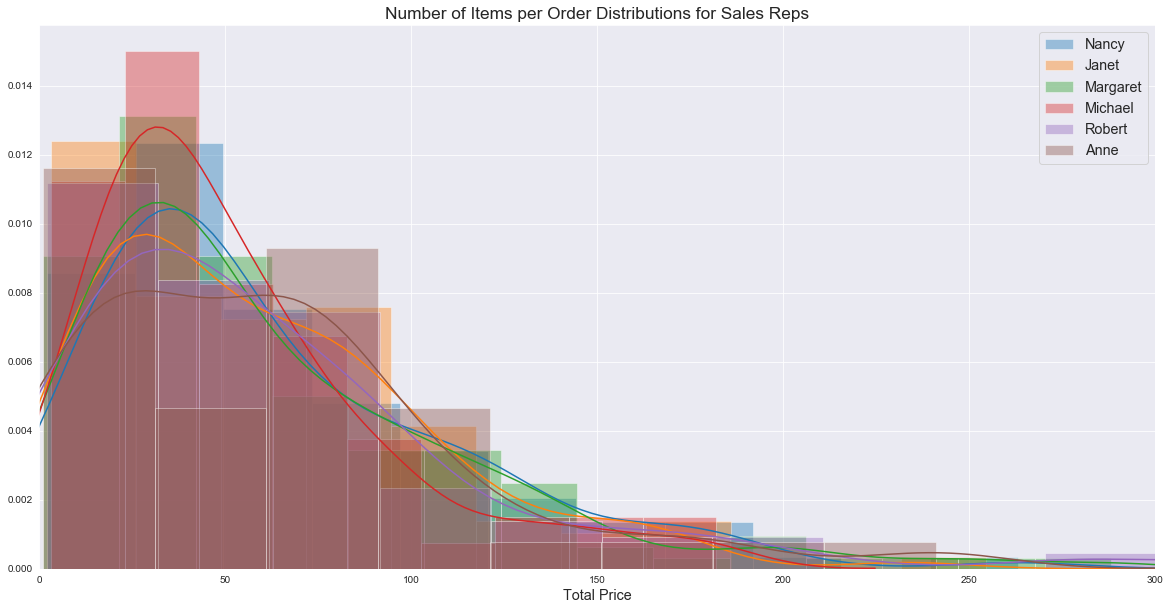

In [137]:
# plot the distribution
fig, ax = plt.subplots(figsize=(20,10))
for rep in sales_reps['FirstName'].unique():
    ax = sns.distplot(sales_reps_qn_dists[rep], label=rep)
ax.legend(fontsize='x-large')
ax.set_title('Number of Items per Order Distributions for Sales Reps', size='xx-large')
ax.set_xlabel('Total Price', size='x-large')
ax.set_xlim(0, 300)

In [141]:
# check normality
detect_abnormality(sales_reps_qn_dists.values())

The distribution at index 0 is not normally distributed; the Shapiro test gave it a pvalue of 2.4691814815014368e-08
The distribution at index 1 is not normally distributed; the Shapiro test gave it a pvalue of 2.2826031342848552e-10
The distribution at index 2 is not normally distributed; the Shapiro test gave it a pvalue of 3.3172679880788536e-11
The distribution at index 3 is not normally distributed; the Shapiro test gave it a pvalue of 7.9152841863106e-06
The distribution at index 4 is not normally distributed; the Shapiro test gave it a pvalue of 9.456496030679773e-09
The distribution at index 5 is not normally distributed; the Shapiro test gave it a pvalue of 0.00040854158578440547


Text(0.5, 0, 'Total Price')

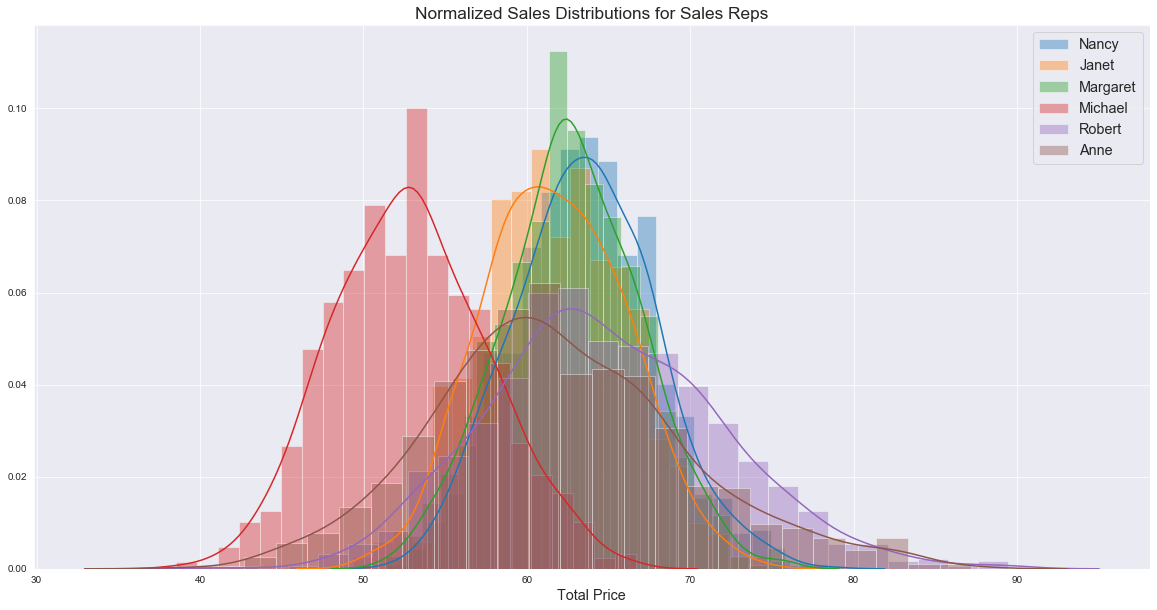

In [142]:
# use bootstrap to get normalized distribution and plot it
qn_bstrap = {}
for name in sales_reps_qn_dists.keys():
    qn_bstrap[name] = bootstrap_em(sales_reps_qn_dists[name], n=1000)

fig, ax = plt.subplots(figsize=(20, 10))
for name in qn_bstrap.keys():
    sns.distplot(qn_bstrap[name], label=name)
ax.legend(fontsize='x-large')
ax.set_title('Normalized Distribution of Number of Items per Order for Sales Reps', size='xx-large')
ax.set_xlabel('Total Price', size='x-large')

In [143]:
# turn into a dataframe for the statistical tests to use
rep_w_ordercount = pd.DataFrame.from_dict(qn_bstrap, orient='index').reset_index()
rep_w_ordercount = pd.melt(rep_w_ordercount, id_vars=["index"], value_name=0).drop(['variable'],axis=1).sort_values('index')
rep_w_ordercount = rep_w_ordercount.rename(columns={'index':'Name', 0:'OrderCount'}).dropna()
print(rep_w_ordercount.describe())
rep_w_ordercount

        OrderCount
count  6000.000000
mean     61.264650
std       6.826223
min      38.552239
25%      57.052966
50%      61.543191
75%      65.555556
max      89.444444


,Name,OrderCount
2999,Anne,79.441860
2609,Anne,63.209302
2603,Anne,59.069767
2597,Anne,61.976744
2591,Anne,52.116279
...,...,...
3100,Robert,70.458333
2254,Robert,63.930556
5326,Robert,71.055556
3748,Robert,46.138889


In [145]:
# ANOVA test
formula = 'OrderCount ~ C(Name)'

anova_test(formula, rep_w_ordercount)

,sum_sq,df,F,PR(>F)
C(Name),91618.557355,5.0,584.466958,0.0
Residual,187918.795147,5994.0,NaN,NaN


In [144]:
# Tukey test
reps_comp = pairwise_tukeyhsd(endog=rep_w_ordercount['OrderCount'], groups=rep_w_ordercount['Name'], alpha=0.05)
print(reps_comp)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower    upper  reject
---------------------------------------------------------
    Anne    Janet  -0.2192    0.9   -0.933  0.4946  False
    Anne Margaret   0.8677 0.0071   0.1539  1.5815   True
    Anne  Michael  -9.0846  0.001  -9.7984 -8.3708   True
    Anne    Nancy   1.6448  0.001    0.931  2.3586   True
    Anne   Robert    2.857  0.001   2.1432  3.5708   True
   Janet Margaret   1.0869  0.001   0.3731  1.8007   True
   Janet  Michael  -8.8654  0.001  -9.5792 -8.1516   True
   Janet    Nancy   1.8639  0.001   1.1501  2.5777   True
   Janet   Robert   3.0762  0.001   2.3623    3.79   True
Margaret  Michael  -9.9523  0.001 -10.6661 -9.2385   True
Margaret    Nancy   0.7771 0.0236   0.0633  1.4909   True
Margaret   Robert   1.9893  0.001   1.2755  2.7031   True
 Michael    Nancy  10.7294  0.001  10.0156 11.4432   True
 Michael   Robert  11.9416  0.001  11.2278 12.6554   True
   Nancy   Rob

In [152]:
# get effect sizes
rep_pairs = combinations(qn_bstrap.keys(), 2)
for pair in list(rep_pairs):
    e_size = cohens_d(rep_w_ordercount.loc[rep_w_ordercount['Name']==pair[0]]['OrderCount'], rep_w_ordercount.loc[rep_w_ordercount['Name']==pair[1]]['OrderCount'])
    print(f'The effect size for a comparison between {pair[0].upper()} and {pair[1].upper()} is {round(e_size, 2)}')

The effect size for a comparison between NANCY and JANET is 0.43
The effect size for a comparison between NANCY and MARGARET is 0.18
The effect size for a comparison between NANCY and MICHAEL is 2.37
The effect size for a comparison between NANCY and ROBERT is -0.21
The effect size for a comparison between NANCY and ANNE is 0.26
The effect size for a comparison between JANET and MARGARET is -0.25
The effect size for a comparison between JANET and MICHAEL is 1.95
The effect size for a comparison between JANET and ROBERT is -0.52
The effect size for a comparison between JANET and ANNE is -0.03
The effect size for a comparison between MARGARET and MICHAEL is 2.23
The effect size for a comparison between MARGARET and ROBERT is -0.34
The effect size for a comparison between MARGARET and ANNE is 0.14
The effect size for a comparison between MICHAEL and ROBERT is -1.97
The effect size for a comparison between MICHAEL and ANNE is -1.42
The effect size for a comparison between ROBERT and ANNE i

In [157]:
# get cummulative effect sizes
for rep in qn_bstrap.keys():
    e_sizes = []
    for name in qn_bstrap.keys():
        if rep != name:
            e_sizes.append(cohens_d(rep_w_ordercount.loc[rep_w_ordercount['Name']==rep]['OrderCount'], rep_w_ordercount.loc[rep_w_ordercount['Name']==name]['OrderCount']))
    print(f"{rep}'s cummulative effect size is {sum(e_sizes)}")

Nancy's cummulative effect size is 3.042666095827752
Janet's cummulative effect size is 0.7118279657752006
Margaret's cummulative effect size is 2.096934160875653
Michael's cummulative effect size is -9.943666304999663
Robert's cummulative effect size is 3.4267245902134396
Anne's cummulative effect size is 0.6655134923076182


## Conclusion

Here too we found substantial differences between each sales rep; with only Janet and Anne being so close as to be impossible to distinguish with 95% confidence. Interestingly, where Anne and Robert outperformed everyone on the total price of their orders, Anne actually doesn't have any impressive effect size here - one might imagine that she has many small orders with expensive items in them. Michael continues to underperform.